In [15]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import socket


nginx = {
    "name": "Nginx",
    "ip": "nginx.antoniszczepanik.com",
}

h2o = {
    "name": "H2O",
    "ip": "h2o.antoniszczepanik.com",
}

caddy = {
    "name": "Caddy",
    "ip": "caddy.antoniszczepanik.com",
}

ls = {
    "name": "OpenLiteSpeed",
    "ip": "litespeed.antoniszczepanik.com",
}

iperf_port = "6969"

servers = (nginx, h2o, caddy, ls)

#### h2 load output parsing

In [16]:
def get_throughput(res):
    try:
        fin_line = [l for l in res if l.startswith("finished in ")][0]
    except:
        print(res)
    return float(fin_line.split(" ")[-1][:-4])

def get_rps(res):
    fin_line = [l for l in res if l.startswith("finished in ")][0]
    return float(fin_line.split(" ")[3])

def get_success_pct(res):
    req_line = [l for l in res if l.startswith("requests:")][0]
    items = req_line.split(" ")
    return float(items[7])/float(items[1])

### Network impairment tooling

In [17]:
# Show rules
def show():
    !tc qdisc show dev ens5
    print()
    
def add_impairment(loss_pct=0.25, delay_ms=100):
    !sudo tc qdisc add dev ens5 root netem delay {delay_ms}ms
    !sudo tc qdisc change dev ens5 root netem loss {loss_pct}%

def clear_impairment():
    !sudo tc qdisc del dev ens5 root
    
def add_in_loss(pct=0):
    pct *= 0.01
    !sudo iptables -A INPUT -m statistic --mode random --probability {pct} -j DROP

def clear_in_loss():
    !sudo iptables -D INPUT 1
    
def add_all(loss_pct=0.25, delay_ms=100):
    #print(f"set loss to {loss_pct}, set delay to {delay_ms}")
    add_in_loss(loss_pct)
    add_impairment(loss_pct, delay_ms)
    
def clear():
    #print("clear network impairment")
    clear_in_loss()
    clear_impairment()

### Check if h2load and servers are available (single request only)

In [18]:
for server in servers:
    for protocol in ('h2', 'h3'):
        res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/index.html
        print(f"{server['name']:15} {protocol} {[l for l in res if 'requests: ' in l][0]}")


Nginx           h2 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
Nginx           h3 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
H2O             h2 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
H2O             h3 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
Caddy           h2 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
Caddy           h3 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
OpenLiteSpeed   h2 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout
OpenLiteSpeed   h3 requests: 1 total, 1 started, 1 done, 1 succeeded, 0 failed, 0 errored, 0 timeout


## Bandwidth and latency test

### Latency

In [ ]:
for server in servers:
    print("")
    print(f"==================== PING {server['name']} ==========================")
    !ping -c 5 {server["ip"]}

### Bandwidth - TCP & UDP

In [ ]:
# TODO: Make sure iperf is running on all servers.
!iperf -c {nginx["ip"]} -p {iperf_port}
!iperf -u -c {nginx["ip"]} -p {iperf_port} -b 0

### Measuring QUIC performance

#### Bulk Throughput

Get throughput measurment from the client.

In [ ]:
data_tp = {
    "server": [],
    "throughput": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3",):
        print(f"bulk throughput test {protocol} - {server['name']}")
        # Request the file first, just to warm up caches.
        _ = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
        for i in range(1):
            res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
            data_tp['server'].append(server['name'])
            data_tp['throughput'].append(get_throughput(res))
            data_tp['protocol'].append("HTTP/2" if protocol == "h2" else "HTTP/3")
            print(f"{get_throughput(res)} MB/s (succ: {get_success_pct(res)})")

In [ ]:
def get_title_from_subplot(sup_title):
    for s in servers:
        if s['name'].lower() in sup_title.lower():
            return s['name']
    return "ERROR: unknown server"

df_tp = pd.DataFrame(data_tp)
sns.set(rc={'figure.figsize':(30,10)})

# ax = sns.boxplot(x="server", y="throughput", hue="protocol", data=df_tp, palette="Set3")

g = sns.catplot(x="protocol", y="throughput",hue="protocol", col="server",data=df_tp, kind="box",height=8, aspect=.4, palette="Paired");
g.set_xlabels('Protocol')
g.set_ylabels('Throughput (Mb/s)')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)
    plt.yticks(list(range(0, 601, 50)))

In [ ]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(10):
            res = !h2load -n1000000 -t $(nproc) -c 100 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

In [ ]:
df_rps= pd.DataFrame(data_rps)
sns.set(rc={'figure.figsize':(20,10)})


g = sns.catplot(x="protocol", y="rps",hue="protocol", col="server",data=df_rps, kind="box",height=8, aspect=.4, palette="Paired", sharey=False);
g.set_xlabels('Protocol')
g.set_ylabels('Requests per second')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)

# RPS with single connection (vary multiplexing level)

In [ ]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for conn_number in range(5):
            res = !h2load -n100000 -t $(nproc) -c 100 -m 1 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

## RPS with varying loss

## Download scenario with 100ms latency and varying loss 0 - 1.5 %

In [19]:
clear()
data_rps = {
    "server": [],
    "throughput": [],
    "protocol": [],
    "loss": [],
}
for server in servers:
    for protocol in ("h2", "h3"):
        print(f"throughput test {protocol} - {server['name']}")
        for loss_pct in list(np.arange(0,1.6,0.1)):
            add_all(loss_pct, 100)
            for _ in range(1):
                res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
                data_rps['server'].append(server['name'])
                data_rps['protocol'].append(protocol)
                data_rps['loss'].append(loss_pct)
                data_rps['throughput'].append(get_throughput(res))

                print(f"{get_throughput(res)} Mb/s (succ: {get_success_pct(res):.3f})")
            clear()

        print(f"Finished geting measurements for {server['name']} {protocol}")

Error: Cannot delete qdisc with handle of zero.
rps test h2 - Nginx
398.2 Mb/s (succ: 1.000)
377.4 Mb/s (succ: 1.000)
309.02 Mb/s (succ: 1.000)
250.13 Mb/s (succ: 1.000)
196.39 Mb/s (succ: 1.000)
176.71 Mb/s (succ: 1.000)
139.63 Mb/s (succ: 1.000)
131.57 Mb/s (succ: 1.000)
116.05 Mb/s (succ: 1.000)
106.38 Mb/s (succ: 1.000)
91.24 Mb/s (succ: 1.000)
87.12 Mb/s (succ: 1.000)
79.23 Mb/s (succ: 1.000)
70.74 Mb/s (succ: 1.000)
58.84 Mb/s (succ: 1.000)
61.82 Mb/s (succ: 1.000)
Finished geting measurements for Nginx h2
rps test h3 - Nginx
102.16 Mb/s (succ: 1.000)
95.02 Mb/s (succ: 1.000)
90.28 Mb/s (succ: 1.000)
90.15 Mb/s (succ: 1.000)
76.33 Mb/s (succ: 1.000)
75.49 Mb/s (succ: 1.000)
69.49 Mb/s (succ: 1.000)
62.38 Mb/s (succ: 1.000)
61.53 Mb/s (succ: 1.000)
60.49 Mb/s (succ: 1.000)
56.96 Mb/s (succ: 1.000)
57.59 Mb/s (succ: 1.000)
55.47 Mb/s (succ: 1.000)
50.87 Mb/s (succ: 1.000)
52.56 Mb/s (succ: 1.000)
49.54 Mb/s (succ: 1.000)
Finished geting measurements for Nginx h3
rps test h2 - H2O
3

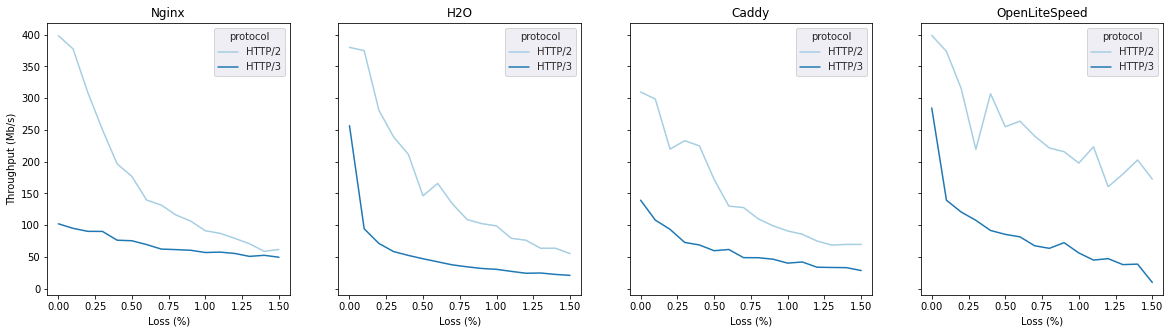

In [20]:
df = pd.DataFrame(data_rps)
df = df.replace({"h2": "HTTP/2", "h3": "HTTP/3"})

f, axs = plt.subplots(1,len(servers),
                      figsize=(20,5),
                      sharey=True)

for i, server in enumerate(servers):
    df_s = df[df['server'] == server['name']]
    sns.set_style("darkgrid")
    lp = sns.lineplot(x="loss", y="throughput", hue="protocol", data=df_s, palette="Paired", ax=axs[i]).set(title=server['name'], xlabel="Loss (%)", ylabel="Throughput (Mb/s)")
    if i > 0:
        axs[i].set(ylabel=None)


plt.show()

## RPS test with 100ms latency and varying loss 0 - 1 %

In [ ]:
clear()
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
    "loss": [],
}
for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for loss_pct in list(np.arange(0,10,1)):
            add_all(loss_pct, 500)
            for _ in range(1):
                res = !h2load -D5s -t $(nproc) -c 100 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
                data_rps['server'].append(server['name'])
                data_rps['protocol'].append(protocol)
                data_rps['loss'].append(loss_pct)
                data_rps['rps'].append(get_rps(res))

                print(f"{get_rps(res)} RPS (succ: {get_success_pct(res):.3f})")
            clear()

        print(f"Finished geting measurements for {server['name']} {protocol}")

In [ ]:
res

In [ ]:
df = pd.DataFrame(data_rps)
df = df.replace({"h2": "HTTP/2", "h3": "HTTP/3"})

f, axs = plt.subplots(1,len(servers),
                      figsize=(20,5),
                      sharey=True)

for i, server in enumerate(servers):
    df_s = df[df['server'] == server['name']]
    sns.set_style("darkgrid")
    lp = sns.lineplot(x="loss", y="rps", hue="protocol", data=df_s, palette="Paired", ax=axs[i]).set(title=server['name'], xlabel="Loss (%)", ylabel="RPS")
    if i > 0:
        axs[i].set(ylabel=None)


plt.show()